In [1]:
!pip install opencv-python-headless opencv-contrib-python open3d matplotlib numpy

  Using cached matplotlib-3.10.7-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached numpy-2.3.4-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pillow-12.0.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pandas-2.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached scikit_learn-1.7.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_metadata-8.7.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using

In [1]:
# All the imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # noqa: F401

In [2]:
# Loading images paths
img1_path = './Data/0001.jpeg'
img2_path = './Data/0002.jpeg'

# Saving the output 3-D points file

ply_out = 'reconstruction_two_view.ply'
# Lowe's ratio
ratio_thresh = 0.75

# RANSAC params for findEssentialMat
ransac_prob = 0.999
ransac_threshold = 1.0

# Visualization flags
show_intermediate = True

In [3]:
# Getting image size (pixel width, height)
def get_image_size(img):
    h, w = img.shape[:2]
    return w, h

# Reading image and converting to RGB
def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f'Could not read image at {path}')
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_rgb = img
    return img, img_rgb


Image size (width x height): 960 x 1280
Image 1 size: 960x1280
Image 2 size: 960x1280 (resized to match Image 1)


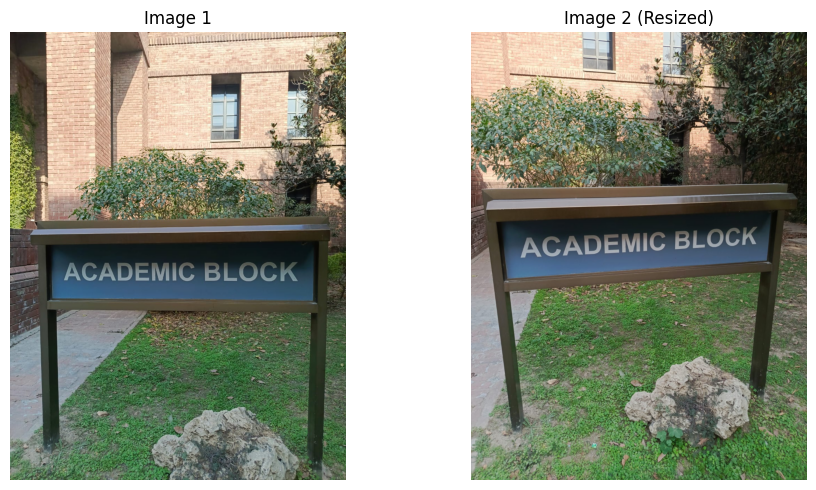

In [4]:
# Loading images
img1_bgr, img1 = read_image(img1_path)
img2_bgr, img2 = read_image(img2_path)
W, H = get_image_size(img1_bgr)
print('Image size (width x height):', W, 'x', H)

# If the two images differ in size, warning
W2, H2 = get_image_size(img2_bgr)
if (W, H) != (W2, H2):
    print('Warning: images have different sizes:', (W, H), (W2, H2))

# Resizing images to same resolution (to avoid Essential Matrix warning) ---

# Get size of first image (target size)
H1, W1 = img1_bgr.shape[:2]
target_size = (W1, H1)

# Resize second image to match first
img2_bgr = cv2.resize(img2_bgr, target_size, interpolation=cv2.INTER_AREA)

# Convert both to RGB for consistency
img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)

print(f"Image 1 size: {img1.shape[1]}x{img1.shape[0]}")
print(f"Image 2 size: {img2.shape[1]}x{img2.shape[0]} (resized to match Image 1)")

# Displaying both images side by side ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title("Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title("Image 2 (Resized)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
# Building camera intrinsic matrix K per project instructions --
# principal point at image center, fx = fy = image width
fx = W
fy = W
cx = W / 2.0
cy = H / 2.0
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1.0]])
print('K =\n', K)

# Feature detection: SIFT
if hasattr(cv2, 'SIFT_create'):
    sift = cv2.SIFT_create()
else:
    # try xfeatures2d
    try:
        sift = cv2.xfeatures2d.SIFT_create()
    except Exception:
        raise RuntimeError('SIFT not available in your OpenCV build. Install opencv-contrib or use ORB.')

kp1, des1 = sift.detectAndCompute(img1_bgr, None)
kp2, des2 = sift.detectAndCompute(img2_bgr, None)
print('Detected keypoints:', len(kp1), 'and', len(kp2))



K =
 [[960.   0. 480.]
 [  0. 960. 640.]
 [  0.   0.   1.]]
Detected keypoints: 12929 and 18158


In [6]:
# Matching: FLANN for SIFT
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good_matches = []
for m,n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

print('Matches after Lowe ratio test:', len(good_matches))


Matches after Lowe ratio test: 439


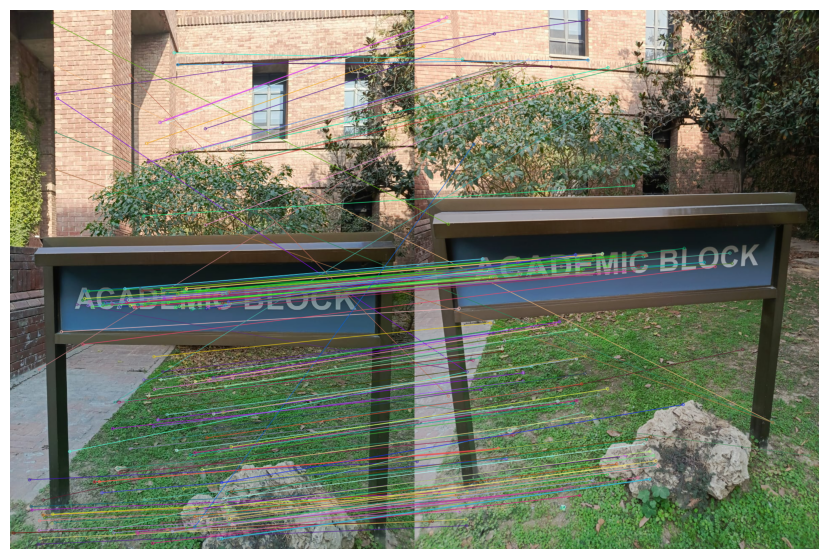

Essential matrix found. Inliers: 312 / 439


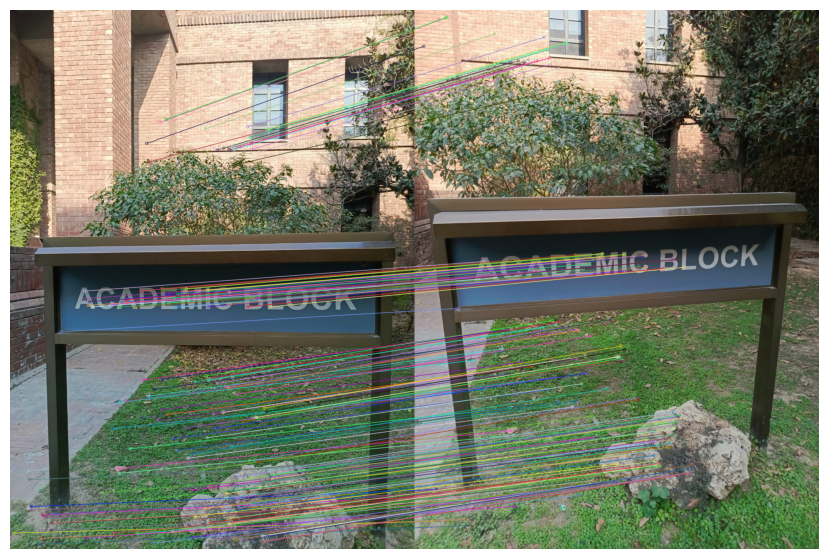

Pose 0: positive depths = 312 / 312
Pose 1: positive depths = 0 / 312
Pose 2: positive depths = 0 / 312
Pose 3: positive depths = 0 / 312
Selected pose with 312 in-front points


In [8]:
# Visualize initial matches (sample up to N for plotting)
def draw_matches(img1, kp1, img2, kp2, matches, out_path=None, max_draw=200):
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:max_draw], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(14,7))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if out_path:
        plt.savefig(out_path, bbox_inches='tight')
    plt.show()

if show_intermediate:
    draw_matches(img1_bgr, kp1, img2_bgr, kp2, good_matches)

# Preparing matched points for Essential matrix estimation
pts1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.array([kp2[m.trainIdx].pt for m in good_matches])

# Converting to float32
pts1f = pts1.reshape(-1,1,2).astype(np.float32)
pts2f = pts2.reshape(-1,1,2).astype(np.float32)


# Estimating Essential matrix with RANSAC
E, mask = cv2.findEssentialMat(pts1f, pts2f, K, method=cv2.RANSAC, prob=ransac_prob, threshold=ransac_threshold)
if E is None:
    raise RuntimeError('Essential matrix estimation failed. Not enough inlier matches or degenerate configuration.')

inlier_mask = mask.ravel().astype(bool)
print('Essential matrix found. Inliers:', inlier_mask.sum(), '/', len(inlier_mask))

# Showing inlier matches
if show_intermediate:
    inlier_matches = [m for i,m in enumerate(good_matches) if inlier_mask[i]]
    draw_matches(img1_bgr, kp1, img2_bgr, kp2, inlier_matches)

# Pose disambiguation: decompose E into four possible poses, triangulate and count points in front
R1, R2, t = cv2.decomposeEssentialMat(E)
possible_poses = [
    (R1,  t),
    (R2,  t),
    (R1, -t),
    (R2, -t),
]

# Converting matched inlier points to undistorted normalized coordinates
pts1_in = pts1[inlier_mask]
pts2_in = pts2[inlier_mask]

# Projection matrices for camera0 (identity) and camera1 (R|t)
P0 = np.hstack((np.eye(3), np.zeros((3,1))))

best_pose = None
best_positive = -1
best_pts3d = None

for i,(R,c_t) in enumerate(possible_poses):
    P1 = np.hstack((R, c_t.reshape(3,1)))
    proj0 = K.dot(P0)
    proj1 = K.dot(P1)
    # Triangulating
    pts4d_h = cv2.triangulatePoints(proj0, proj1, pts1_in.T, pts2_in.T)
    pts3d = (pts4d_h[:3] / pts4d_h[3]).T  # N x 3
    # Cheirality check: count points with positive depth in both cameras
    z0 = pts3d[:,2]
    # Depth in camera1: z of R * X + t
    pts_cam1 = (R.dot(pts3d.T) + c_t.reshape(3,1)).T
    z1 = pts_cam1[:,2]
    num_positive = np.sum((z0 > 0) & (z1 > 0))
    print(f'Pose {i}: positive depths =', int(num_positive), '/', pts3d.shape[0])
    if num_positive > best_positive:
        best_positive = int(num_positive)
        best_pose = (R, c_t)
        best_pts3d = pts3d

if best_pose is None:
    raise RuntimeError('Pose disambiguation failed.')

R_final, t_final = best_pose
print('Selected pose with', best_positive, 'in-front points')



In [9]:
# Sample colors from img1 (RGB) at rounded keypoint coords
colors = []
for (x,y) in pts1_in:
    xi = int(round(x))
    yi = int(round(y))
    xi = np.clip(xi, 0, img1.shape[1]-1)
    yi = np.clip(yi, 0, img1.shape[0]-1)
    colors.append(img1[yi, xi])
colors = np.array(colors).astype(np.uint8)

# Keeping only points that passed cheirality (both depths > 0)
# Recomputing to ensure correspondence with best_pose
P1_best = np.hstack((R_final, t_final.reshape(3,1)))
proj0 = K.dot(P0)
proj1 = K.dot(P1_best)
pts4d_h = cv2.triangulatePoints(proj0, proj1, pts1_in.T, pts2_in.T)
pts3d_all = (pts4d_h[:3] / pts4d_h[3]).T
z0 = pts3d_all[:,2]
pts_cam1 = (R_final.dot(pts3d_all.T) + t_final.reshape(3,1)).T
z1 = pts_cam1[:,2]
valid_idx = np.where((z0 > 0) & (z1 > 0))[0]
pts3d_valid = pts3d_all[valid_idx]
colors_valid = colors[valid_idx]
print('Final points kept after cheirality test:', pts3d_valid.shape[0])

# Write simple PLY (with RGB colors)
def write_ply(filename, points, colors=None):
    n = points.shape[0]
    with open(filename, 'w') as f:
        f.write('ply\n')
        f.write('format ascii 1.0\n')
        f.write(f'element vertex {n}\n')
        f.write('property float x\n')
        f.write('property float y\n')
        f.write('property float z\n')
        if colors is not None:
            f.write('property uchar red\n')
            f.write('property uchar green\n')
            f.write('property uchar blue\n')
        f.write('end_header\n')
        for i in range(n):
            x,y,z = points[i]
            if colors is not None:
                r,g,b = colors[i]
                f.write(f'{x} {y} {z} {int(r)} {int(g)} {int(b)}\n')
            else:
                f.write(f'{x} {y} {z}\n')

write_ply(ply_out, pts3d_valid, colors_valid)
print('Saved PLY to', ply_out)

Final points kept after cheirality test: 312
Saved PLY to reconstruction_two_view.ply


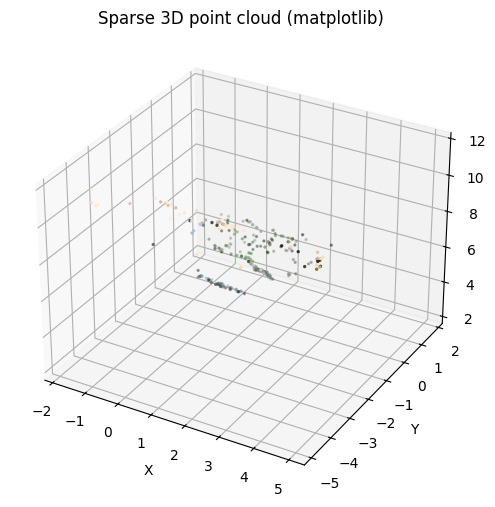

In [10]:
# 3D visualization (inline). matplotlib 3D scatter.
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
xyz = pts3d_valid
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=colors_valid/255.0, s=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Sparse 3D point cloud (matplotlib)')
plt.show()
# %%
# End of notebook